In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder

from sklearn.tree            import DecisionTreeClassifier
from sklearn.naive_bayes     import GaussianNB

dfClassified = pd.read_csv("classification_data.csv")

In [17]:
# Convert string columns into numeric - 'Hotel Name'
hotelNames = dfClassified["Hotel Name"]
le = LabelEncoder()
numericHotels = list(le.fit_transform(hotelNames.tolist()))
dfClassified["Hotel Name"] = pd.Series((numericName for numericName in numericHotels))

In [18]:
# Convert Dates columns into numeric - 'Checkin Date', 'Snapshot Date', 'DayDiff', 'WeekDay'

# Set Date & numeric columns types
dfClassified['Checkin Date']  = pd.to_datetime(dfClassified['Checkin Date'])
dfClassified['Snapshot Date'] = pd.to_datetime(dfClassified['Snapshot Date'])
dfClassified['DayDiff']       = pd.to_numeric(dfClassified['DayDiff'])

# Change columns to have numeric values for later ML algorithms usage
dfClassified['WeekDay']       = dfClassified['Checkin Date'].apply(lambda x: x.weekday())
dfClassified['Checkin Date']  = dfClassified['Checkin Date'].apply(lambda x: x.timestamp())
dfClassified['Snapshot Date'] = dfClassified['Snapshot Date'].apply(lambda x: x.timestamp())
dfClassified['DayDiff']       = dfClassified['DayDiff'].apply(lambda x: float(x))

In [19]:
data = pd.DataFrame(dfClassified, columns=['Snapshot Date','Checkin Date','DayDiff','Hotel Name','WeekDay'])
target = pd.DataFrame(dfClassified, columns=['Discount Code'])

trainData, testData, trainTarget, testTarget = train_test_split(data, target)

In [20]:
dt = DecisionTreeClassifier()
dt.fit(trainData, trainTarget)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(dt.score(trainData, trainTarget)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'    .format(dt.score(testData, testTarget)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.78


In [21]:
nb = GaussianNB()
nb.fit(trainData, trainTarget)

print('Accuracy of Naive Bayes classifier on training set: {:.2f}'.format(nb.score(trainData, trainTarget)))
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'    .format(nb.score(testData, testTarget)))

c:\users\ofri1\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Naive Bayes classifier on training set: 0.32
Accuracy of Naive Bayes classifier on test set: 0.32


##### The differences between Algorithms
As we see, Decision tree algorithm is highly superior than Naive Bayes algorithm in our case.

General information
----------------------------
The Naive Bayes based on the Bayes law in statistics.
The algorithm is considered to be much easier to implement than the decision tree and generic for many different cases.
It works best when parameters are independent,
In our case, There is dependent between parameters [like Checkin Date & WeekDay), and it is probably explains the results.

The main disadvantege of the decision tree algorithm, is that it tends to overfit that data - 
as in the classifier has such a strong structure from the test data, that a new piece of information unknown to it might cause it to give incorrect results.
this can be handled by pruning.

In [22]:
# ['Snapshot Date', 'Checkin Date', 'DayDiff', 'Hotel Name', 'WeekDay']
dt.feature_importances_

array([0.21899358, 0.20789928, 0.17015059, 0.37254391, 0.03041264])

Parameter influence order - order by desc.
* Hotel Name
* Snapshot Date
* Checkin Date
* DayDiff
* WeekDay

In [23]:
numOfClasses = dfClassified["Discount Code"].unique().size

In [24]:
def printFnAndFpIndices(confusion_matrix):
    tp = np.diag(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    tn = confusion_matrix.sum() - (tp + fp + fn)
    
    fnPerClass = []
    fpPerClass = []
    for i in range(numOfClasses):
        fnPerClass.insert(i, float(fn[i]) / (tp[i]+fn[i]))
        fpPerClass.insert(i, float(fp[i]) / (fp[i]+tn[i]))
        
    
    print('False Negative')
    print(fnPerClass)
    print('False Poisitive')
    print(fpPerClass)

In [25]:
from sklearn.metrics import confusion_matrix
dtPredicated = dt.predict(testData)
dt_confusion_matrix = confusion_matrix(testTarget, dtPredicated)
print("indices for decision tree")
printFnAndFpIndices(dt_confusion_matrix)
nbPredicated = nb.predict(testData)
nb_confusion_matrix = confusion_matrix(testTarget, dtPredicated)
print("indices for naive base")
printFnAndFpIndices(nb_confusion_matrix)


indices for decision tree
False Negative
[0.21721664275466285, 0.2136310223266745, 0.21291932353756585, 0.23795691115952552]
False Poisitive
[0.07559808612440191, 0.09702429702429702, 0.07949620111162103, 0.04468141358949502]
indices for naive base
False Negative
[0.21721664275466285, 0.2136310223266745, 0.21291932353756585, 0.23795691115952552]
False Poisitive
[0.07559808612440191, 0.09702429702429702, 0.07949620111162103, 0.04468141358949502]


Roc curve graph for decision tree al


c:\users\ofri1\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


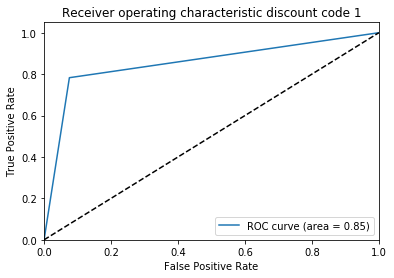

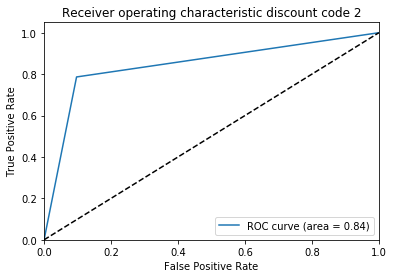

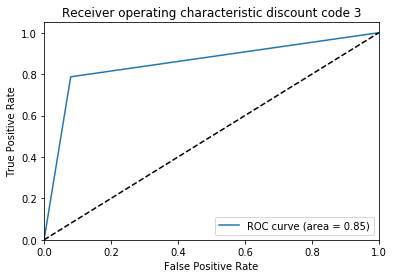

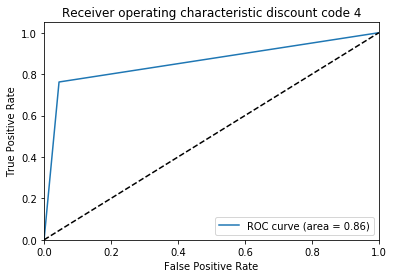

c:\users\ofri1\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


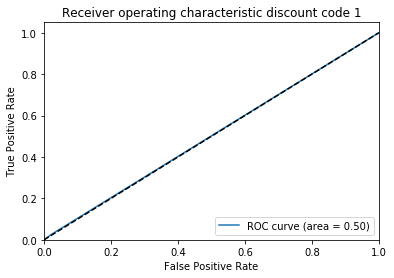

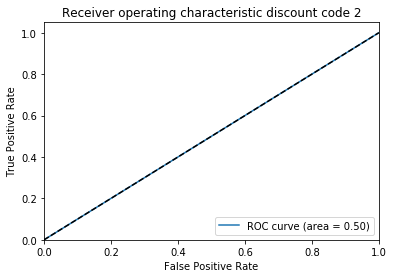

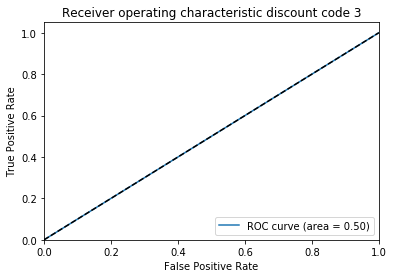

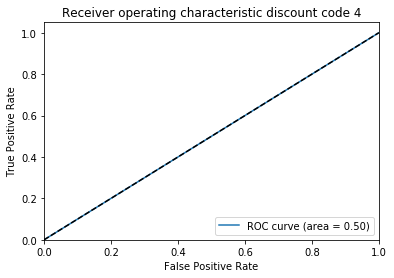

In [26]:
# Lets calculate the ROC for each discount code
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
def printRocGraph(expected, predicated) : 
    exp = label_binarize(expected.as_matrix(), classes=[1, 2, 3, 4])
    pred = label_binarize(predicated, classes=[1, 2, 3, 4])
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(numOfClasses):
        fpr[i], tpr[i], _ = roc_curve(exp[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    for i in range(numOfClasses):
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic ' + 'discount code ' + str(i+1))
        plt.legend(loc="lower right")
        plt.show()
        
print("Roc curve graph for decision tree al")
printRocGraph(testTarget, dtPredicated) 
printRocGraph(testTarget, nbPredicated) 
    


In our case, Decision Tree is much but in his ROC,
which means that the DT algorithm predict better than Naive Bayes.

#### Higher ROC Curve means:
* Higher TP, TN Rates
* Lower  FN, FP Rates